In [1]:
from scipy.optimize import fsolve
import math
import csv
import matplotlib.pyplot as plt #pip install matplotlib
from scipy.interpolate import interp1d
import numpy as np

In [2]:
class atmosphere_:
    def __init__(self, file_name):
        print('Atmosphere class inited') 
        self.htab, self.ptab, self.rhotab, self.atab = [], [], [], []
        self.gtab, self.Ttab, self.nutab, self.mutab = [], [], [], []
        with open('Таблица-ГОСТ4401-81-до-100-км.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter="\t", quotechar='|')
            for line in spamreader:
                #h p rho a g T nu 	mu
                self.htab.append(float(line[0].strip('"')))
                self.ptab.append(float(line[1].strip('"')))
                self.rhotab.append(float(line[2].strip('"')))
                self.atab.append(float(line[3].strip('"')))
                self.gtab.append(float(line[4].strip('"')))
                self.Ttab.append(float(line[5].strip('"')))
                self.nutab.append(float(line[6].strip('"')))
                self.mutab.append(float(line[7].strip('"')))
        self.htab, self.ptab, self.rhotab, self.atab = np.array(self.htab), np.array(self.ptab), np.array(self.rhotab), np.array(self.atab)
        self.gtab, self.Ttab, self.nutab, self.mutab = np.array(self.gtab), np.array(self.Ttab), np.array(self.nutab), np.array(self.mutab)
        self.p_interp = interp1d(self.htab, self.ptab)
        self.rho_interp = interp1d(self.htab, self.rhotab)
        self.a_interp = interp1d(self.htab, self.atab)
        self.g_interp = interp1d(self.htab, self.gtab)
        self.T_interp = interp1d(self.htab, self.Ttab)
        self.nu_interp = interp1d(self.htab, self.nutab) # Кинематическая вязкость воздуха
        self.mu_interp = interp1d(self.htab, self.mutab)

    def plot_param(self):
        fig, axs = plt.subplots(2, 3, figsize=(16, 12), sharey = True)
        w_line = 3
        axs[0][0].plot(self.p_interp(self.htab), self.htab, c = 'red', linewidth = w_line, alpha = 0.5)
        axs[0][1].plot(self.rho_interp(self.htab), self.htab, c = 'green', linewidth = w_line, alpha = 0.5)
        axs[0][2].plot(self.T_interp(self.htab), self.htab, c = 'blue', linewidth = w_line, alpha = 0.5)
        axs[1][0].plot(self.a_interp(self.htab), self.htab, c = 'brown', linewidth = w_line, alpha = 0.5)
        axs[1][1].plot(self.g_interp(self.htab), self.htab, c = 'k', linewidth = w_line, alpha = 0.5)
        axs[1][2].plot(self.nu_interp(self.htab), self.htab, c = 'y', linewidth = w_line, alpha = 0.5)
        axs[0][0].grid()
        axs[0][1].grid()
        axs[0][2].grid()
        axs[1][0].grid()
        axs[1][1].grid()
        axs[1][2].grid()
        axs[0][0].set_ylabel("Высота, м")
        axs[0][1].set_ylabel("Высота, м")
        axs[0][0].set_xlabel("Давление, Па")
        axs[0][1].set_xlabel("Плотность, -")
        axs[0][2].set_xlabel("Температура, С")
        axs[1][0].set_xlabel("Скорость звука, м/с")
        axs[1][1].set_xlabel("Ускорение свободного падения, м/с^2")
        axs[1][2].set_xlabel("Кинематическая вязкость, ?")
        plt.ylim(-2000, 80000)
        plt.show()

Atmosphere class inited


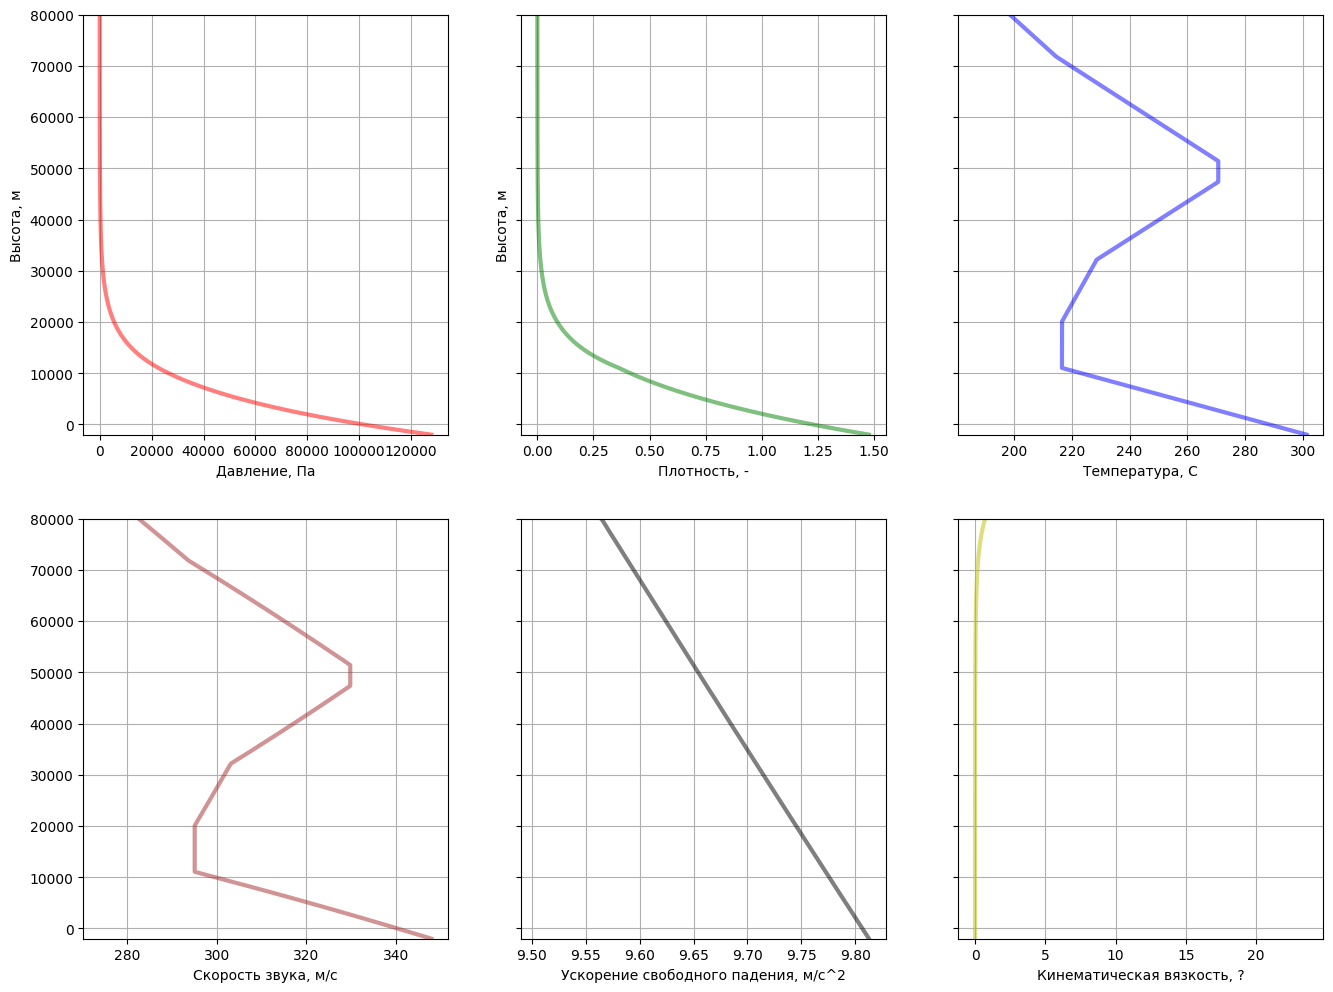

In [3]:
atmosphere_filename = 'Таблица-ГОСТ4401-81-до-100-км.csv'
atm = atmosphere_(atmosphere_filename) # Инициализация класса атмосферы
atm.plot_param() # Построение графических зависимостей атмосферы

In [4]:
def get_V_ob(D, beta):
    return 1.2*D*(math.sqrt(1+32/27*beta) - 1)/(math.sqrt(1+32/27*beta) + 1)

def get_F(S_m, a, b, c):
    return S_m / (a*b*c)**(2/3)

def get_A(rho, S_m, c_x, m_gpe_1):
    up = rho*S_m*c_x
    down = 2*m_gpe_1
    return up/down

def get_C(S_m, H_0, m_gpe_1):
    return S_m*H_0/m_gpe_1

def get_V_psp(C, A, b_pregr, k):
    pow = 2*A*b_pregr/k
    return math.sqrt(C/A*(math.exp(pow) - 1))

def get_A_n(rho_v, c_x, F, rho_osk, m_gpe_1):
    up = rho_v * c_x * F
    down = 2 * rho_osk * m_gpe_1
    return up/down

In [5]:
class obj:
    def __init__(self, b_pregr, rho_p, H_0, k, c_x, rho_v):
        self.b_pregr = b_pregr
        self.rho_p = rho_p
        self.H_0 = H_0
        self.k = k
        self.c_x = c_x
        self.rho_v = rho_v
        self.S_m = None
        self.F = None

        self.m_bch = 14.8 # кг - масса боевой части
        self.m_dop = 1.5 # кг - суммарная масса других элементов, входящих в отсек БЧ
        self.rho_osk = 9800 # кг/м^3 - плотность ГПЭ

        self.a, self.b, self.c = 20e-3, 10e-3, 50e-3 # м - грани параллепипеда ГПЭ
        self.N = 80

        self.D = 8.3 # км/с - скорость детонации ВВ

    def equations(self, p):
        x = p
        return self.V_ob*1000*math.exp(-1*self.A_n*x) - self.V_psp
    
    def calculate(self):
        self.m_gpe = self.N * self.a * self.b * self.c * self.rho_osk
        self.m_gpe_1 = self.a * self.b * self.c * self.rho_osk
        self.m_vv = self.m_bch - self.m_gpe - self.m_dop # кг - масса ВВ
        self.beta = self.m_vv / self.m_gpe
        self.V_ob = get_V_ob(self.D, self.beta)
        self.S_m = (self.a*self.b+self.a*self.c)/2
        self.F = get_F(self.S_m, self.a, self.b, self.c)
        self.A = get_A(self.rho_p, self.S_m, self.c_x, self.m_gpe_1)
        self.C = get_C(self.S_m, self.H_0, self.m_gpe_1)
        self.V_psp = get_V_psp(self.C, self.A, self.b_pregr, self.k)
        self.F = 1.487
        self.A_n = get_A_n(self.rho_v, self.c_x, self.F, self.rho_osk, self.m_gpe_1)
        self.x =  fsolve(self.equations, (1))
        self.I_ub = self.x[0]

    def get_info(self):
        print('m_gpe =', self.m_gpe)
        print('m_gpe_1 =', self.m_gpe_1)
        print('m_vv =', self.m_vv)
        print('beta =', self.beta)
        print('V_ob =', self.V_ob)
        print('S_m =', self.S_m)
        print('F =', self.F)
        print('A =', self.A)
        print('C =', self.C)
        print('V_psp =', self.V_psp)
        print('A_n =', self.A_n)
        print('self.I_ub =', self.I_ub)
        
class Bairactar_(obj):
    def __init__(self, b_pregr, rho_p, H_0, k, c_x, rho_v):
        super().__init__(b_pregr, rho_p, H_0, k, c_x, rho_v)

class FF_18A_(obj):
    def __init__(self, b_pregr, rho_p, H_0, k, c_x, rho_v):
        super().__init__(b_pregr, rho_p, H_0, k, c_x, rho_v)

In [6]:
Bairactar = Bairactar_(b_pregr=3, rho_p=1000, H_0=100, k=1.25, c_x=1.1, rho_v=1.213)
Bairactar.calculate()
Bairactar.get_info()

m_gpe = 7.840000000000001
m_gpe_1 = 0.098
m_vv = 5.46
beta = 0.6964285714285714
V_ob = 1.4872709647507776
S_m = 0.0006000000000000001
F = 1.487
A = 3.3673469387755106
C = 0.6122448979591837
V_psp = 1379.1995300250142
A_n = 0.0010329571532694713
self.I_ub = 73.032645060709


In [7]:
FF_18A = FF_18A_(b_pregr=5, rho_p=2490, H_0=150, k=4.99, c_x=1.1, rho_v=1.202)
FF_18A.calculate()
FF_18A.get_info()

m_gpe = 7.840000000000001
m_gpe_1 = 0.098
m_vv = 5.46
beta = 0.6964285714285714
V_ob = 1.4872709647507776
S_m = 0.0006000000000000001
F = 1.487
A = 8.384693877551022
C = 0.9183673469387755
V_psp = 1473.9689373011415
A_n = 0.0010235898583923365
self.I_ub = 8.777102890522357


### Байрактар

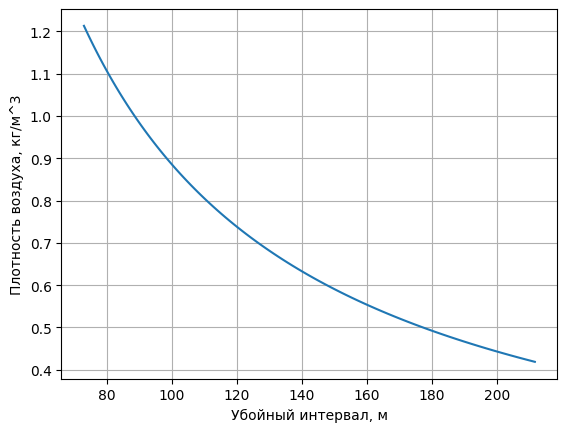

In [8]:
Bairactar = Bairactar_(b_pregr=3, rho_p=1000, H_0=100, k=1.25, c_x=1.1, rho_v=1.213)
plot = {            # массивы для графиков
    'rho_v': [], 
    'I_ub': []
}
for h in range(100, 10000, 100): # варьирование высоты с шагом 100 м
    Bairactar.rho_v = float(atm.rho_interp(h)) # перерасчет плотности воздуха в зависимости от высоты
    Bairactar.calculate()                       # перерасчет всех хар-тик
    plot['rho_v'].append(Bairactar.rho_v)       # добавления элементов в массив
    plot['I_ub'].append(Bairactar.I_ub)

plt.plot(plot['I_ub'], plot['rho_v'])
plt.xlabel('Убойный интервал, м')           # название оси x
plt.ylabel('Плотность воздуха, кг/м^3')     # название оси y
plt.grid()              # сетка

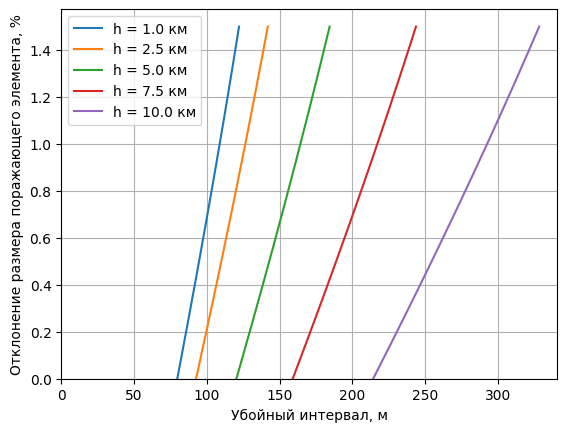

In [10]:
Bairactar = Bairactar_(b_pregr=3, rho_p=1000, H_0=100, k=1.25, c_x=1.1, rho_v=1.213)
plot = {
    'persent': [],
    'I_ub': []
}
res_h = []
var_h = [1000, 2500, 5000, 7500, 10000]
for h in var_h:
    plot = {
    'persent': [],
    'I_ub': [],
    'h': h
    }
    Bairactar.rho_v = float(atm.rho_interp(h))
    for pers in range(0, 1500, 1):
        pers /= 1000

        Bairactar.a, Bairactar.b, Bairactar.c = 20e-3, 10e-3, 50e-3
        Bairactar.a += pers/100*Bairactar.a
        Bairactar.b += pers/100*Bairactar.b
        Bairactar.c += pers/100*Bairactar.c
        Bairactar.calculate()

        plot['persent'].append(pers)

        if Bairactar.I_ub < 0:
            Bairactar.I_ub = 0
        plot['I_ub'].append(Bairactar.I_ub)
    res_h.append(plot)

for plot in res_h:
    plt.plot(plot['I_ub'], plot['persent'], label='h = '+str(plot['h']/1000)+' км')
plt.xlabel('Убойный интервал, м')
plt.ylabel('Отклонение размера поражающего элемента, %')
plt.grid()
plt.xlim(0)
plt.ylim(0)
plt.legend()

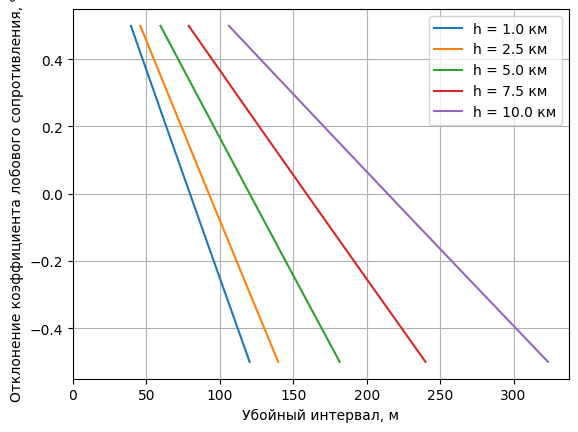

In [13]:
Bairactar = Bairactar_(b_pregr=3, rho_p=1000, H_0=100, k=1.25, c_x=1.1, rho_v=1.213)
plot = {
    'persent': [],
    'I_ub': []
}
res_h = []
var_h = [1000, 2500, 5000, 7500, 10000]
for h in var_h:
    plot = {
    'persent': [],
    'I_ub': [],
    'h': h
    }
    Bairactar.rho_v = float(atm.rho_interp(h))
    for pers in range(-500, 500, 1):
        pers /= 1000

        Bairactar.c_x = 1.1
        Bairactar.c_x += pers/100*Bairactar.c_x
        Bairactar.calculate()

        plot['persent'].append(pers)

        if Bairactar.I_ub < 0:
            Bairactar.I_ub = 0
        plot['I_ub'].append(Bairactar.I_ub)
    res_h.append(plot)

for plot in res_h:
    plt.plot(plot['I_ub'], plot['persent'], label='h = '+str(plot['h']/1000)+' км')
plt.xlabel('Убойный интервал, м')
plt.ylabel('Отклонение коэффициента лобового сопротивления, %')
plt.grid()
plt.xlim(0)
plt.legend()